In [2]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams['figure.dpi'] = 200

# Red clover assembly scaffold network analysis
---

My goal with this exercise is to create networks of all of the major linkage data groups I've collected and then to examine the topology of those networks to try to find a final scaffold consensus. 

Once I determine the reliability of each method and the information behind each data type, I will then try to manually inspect associations to put scaffolds into groups. The linkage EST data is unlikely to be useful in all cases, but other groups might provide hints for final linkage group assignment.

First, let's load the data.

In [70]:
attr = pd.read_csv("C:/SharedFolders/sequencing_projects/red_clover/graph_comps/hifiScaffolds_attributes.tab", 
                   sep="\t", header=(0))
datatypes = ("bacends", "estlinks", "ont")
colors = {"LG1" : 'b', "LG2" : 'g', "LG3" : 'r', "LG4" : 'w', "LG5" : 'c', "LG6" : 'm', "LG7" : 'y', "Unassigned" : 'k'}

dfs = dict()
for i in datatypes:
    dfs[i] = pd.read_csv(f'C:/SharedFolders/sequencing_projects/red_clover/graph_comps/hifiScaffolds_{i}.bigraph', 
                         sep="\t", names=("scaff1", "scaff2", "weight"))
    
graphs = dict()
for i in datatypes:
    graphs[i] = nx.Graph()
    
    print(f'Working on {i}')
    for index, row in dfs[i].iterrows():
        s1 = attr.loc[attr['Scaffold'] == row['scaff1']]
        #print(s1["LG"].values[0])
        graphs[i].add_node(row["scaff1"], color=colors[s1["LG"].values[0]], 
                          length = s1["Length"].values[0])
        s2 = attr.loc[attr['Scaffold'] == row['scaff2']]
        graphs[i].add_node(row["scaff2"], color=colors[s2["LG"].values[0]],
                          length = s2["Length"].values[0])
        
        graphs[i].add_edge(row["scaff1"], row["scaff2"], weight=row["weight"])
    
    transiv = nx.transitivity(graphs[i])
    print(f'Found transitivity of {transiv}')

Working on bacends
Found transitivity of 0.6060828411050372
Working on estlinks
Found transitivity of 0.30413625304136255
Working on ont
Found transitivity of 0.342508377213978


---
#### Graphs

OK, the data is loaded. Let's plot the graphs and see how they look.

bacends Network plot


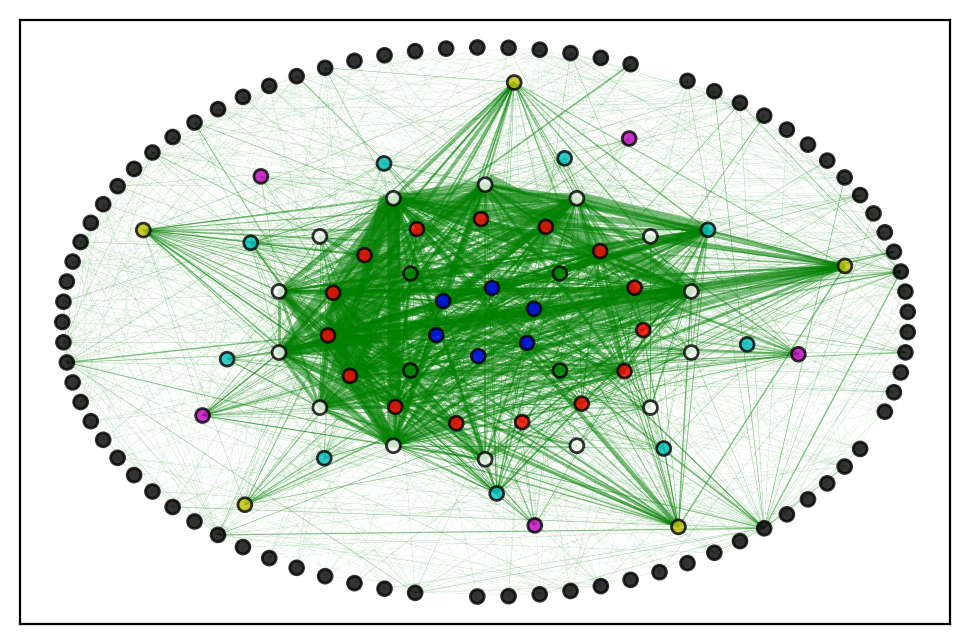

In [71]:
f = "bacends"
shells = {"LG1" : 0, "LG2" : 1, "LG3" : 2, "LG4" : 3, "LG5" : 4, "LG6" : 5, "LG7" : 6, "Unassigned" : 7}
nShellList = list()
for i in range(8):
    nShellList.append(list())
for index, row in attr.iterrows():
    nShellList[shells[row["LG"]]].append(row["Scaffold"])

#pos = nx.spring_layout(graphs[f], k=0.11)
print(f'{f} Network plot')
pos = nx.shell_layout(graphs[f], nlist=nShellList)
nColors = nx.get_node_attributes(graphs[f], 'color')
nx.draw_networkx_nodes(graphs[f], pos, nodelist=[n for n in graphs[f].nodes()], 
                       node_color=[nColors[n] for n in graphs[f].nodes()], node_size=25, node_shape='o', 
                       edgecolors='k', alpha=0.8)

weights = list(nx.get_edge_attributes(graphs[f], 'weight').values())
wmax = max(weights)
fweights = list(map(lambda x: float(x /wmax) * 10.0, list(weights)))

nx.draw_networkx_edges(graphs[f], pos, edgelist=graphs[f].edges(), width=fweights,
                       alpha = 0.5, edge_color='g')

estlinks Network plot


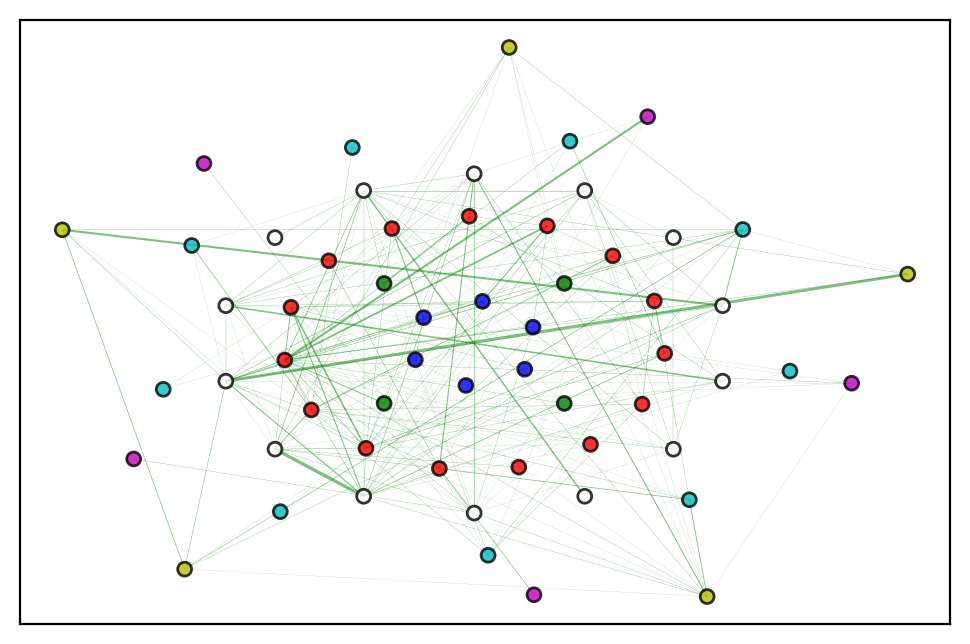

In [72]:
f = "estlinks"

print(f'{f} Network plot')
pos = nx.shell_layout(graphs[f], nlist=nShellList)
nColors = nx.get_node_attributes(graphs[f], 'color')
nx.draw_networkx_nodes(graphs[f], pos, nodelist=[n for n in graphs[f].nodes()], 
                       node_color=[nColors[n] for n in graphs[f].nodes()], node_size=25, node_shape='o', 
                       edgecolors='k', alpha=0.8)

weights = list(nx.get_edge_attributes(graphs[f], 'weight').values())
wmax = max(weights)
fweights = list(map(lambda x: float(x /wmax) * 10.0, list(weights)))

nx.draw_networkx_edges(graphs[f], pos, edgelist=graphs[f].edges(), width=fweights,
                       alpha = 0.5, edge_color='g')

ont Network plot


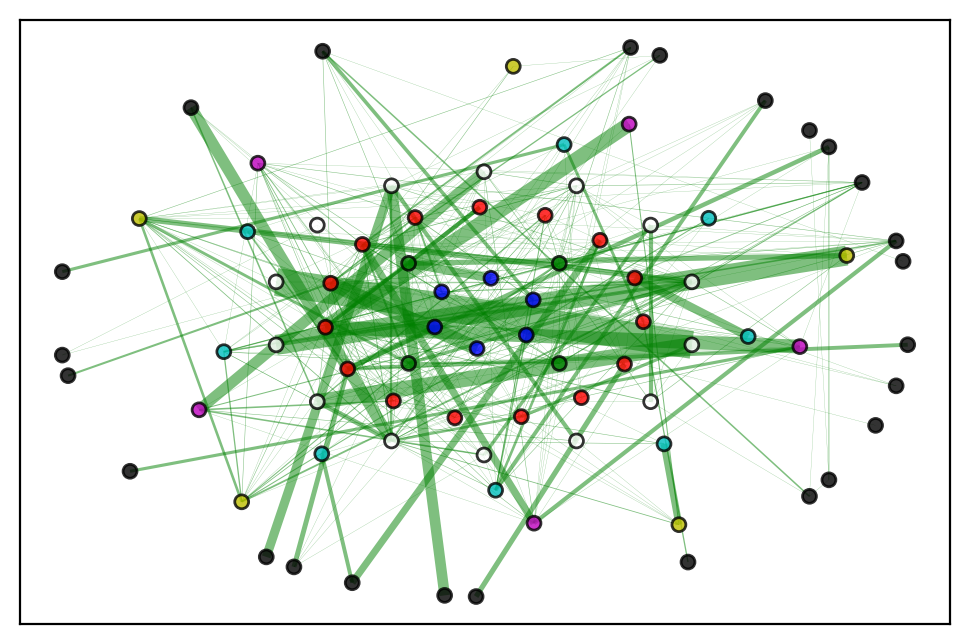

In [73]:
f = "ont"

print(f'{f} Network plot')
pos = nx.shell_layout(graphs[f], nlist=nShellList)
nColors = nx.get_node_attributes(graphs[f], 'color')
nx.draw_networkx_nodes(graphs[f], pos, nodelist=[n for n in graphs[f].nodes()], 
                       node_color=[nColors[n] for n in graphs[f].nodes()], node_size=25, node_shape='o', 
                       edgecolors='k', alpha=0.8)

weights = list(nx.get_edge_attributes(graphs[f], 'weight').values())
wmax = max(weights)
fweights = list(map(lambda x: float(x /wmax) * 10.0, list(weights)))

nx.draw_networkx_edges(graphs[f], pos, edgelist=graphs[f].edges(), width=fweights,
                       alpha = 0.5, edge_color='g')

---
#### Decision time

OK, so the graphs correspond to the terrible situation that I saw before. Basically, the picture is occluded by the presence of many possible paths for the graph. I may need to select each unassigned scaffold and try to assign them based on the ONT read alignments to make any progress. First though, let's see how much sequence is present in each dataset.

In [74]:
nucleotides = list()
for i in datatypes:
    lengths = list(nx.get_node_attributes(graphs[i], 'length').values())
    c = sum(lengths)
    nucleotides.append(c)
    
ntable = pd.DataFrame({"types" : datatypes, "sums" : nucleotides}, columns=["types", "sums"])
ntable.head()

,types,sums
0,bacends,413250846
1,estlinks,405223089
2,ont,408730361


So in the ONT dataset, we add 3 Mbp more than the EST dataset. That's not amazing, but it is more than previous scaffolding. I think that the BAC end dataset is just too messy. Let's try to resolve linkage with the consolidated network using the nodes from the ONT dataset.

---

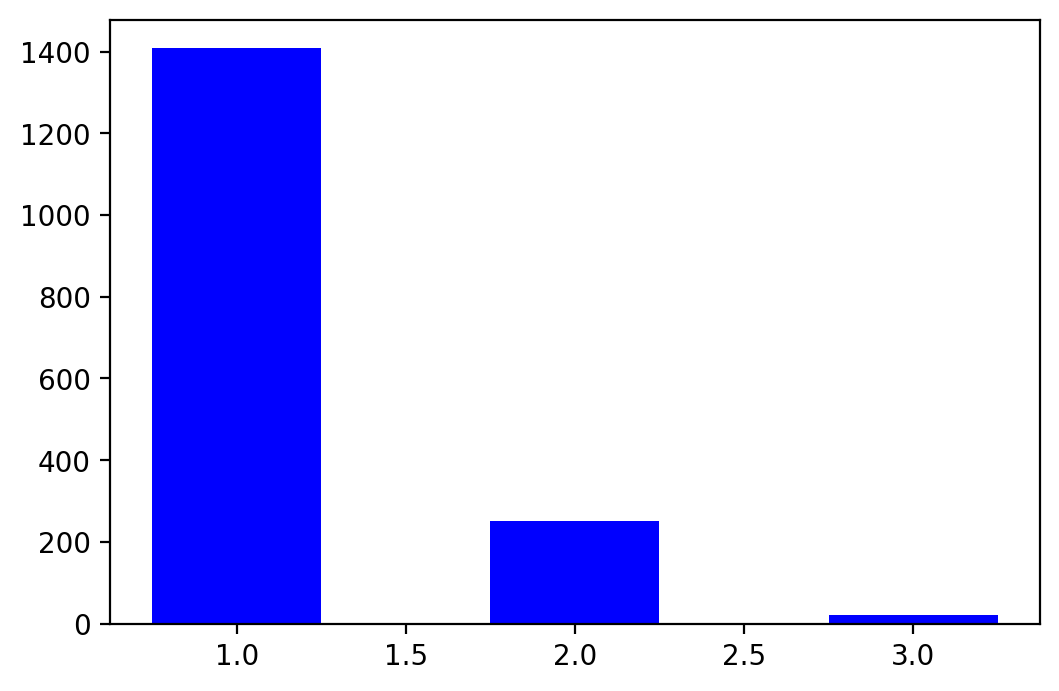

In [75]:
from collections import defaultdict

consolidate = nx.create_empty_copy(graphs["ont"], with_data=True)
#consolidate.add_nodes_from(graphs["ont"].nodes)

newEdges = defaultdict(int)
isPresent = set(list(graphs["ont"].nodes))

for f in ("bacends", "estlinks", "ont"):
    for index, edgeNode in enumerate(list(graphs[f].edges)):
        if edgeNode[0] in isPresent and edgeNode[1] in isPresent:
            newEdges[edgeNode] += 1

valueCats = defaultdict(int)
colorCats = {3 : (1.0, 0.0, 0.0), 2 : (0.0, 1.0, 0.0), 1 : (0.0, 0.0, 1.0)}
for edgeNode, v in newEdges.items():
    valueCats[v] += 1
    consolidate.add_edge(edgeNode[0], edgeNode[1], weight=v, color=colorCats[v])
    
plt.bar(list(valueCats.keys()), valueCats.values(), width=0.5, color="b")
plt.show()

[Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')]

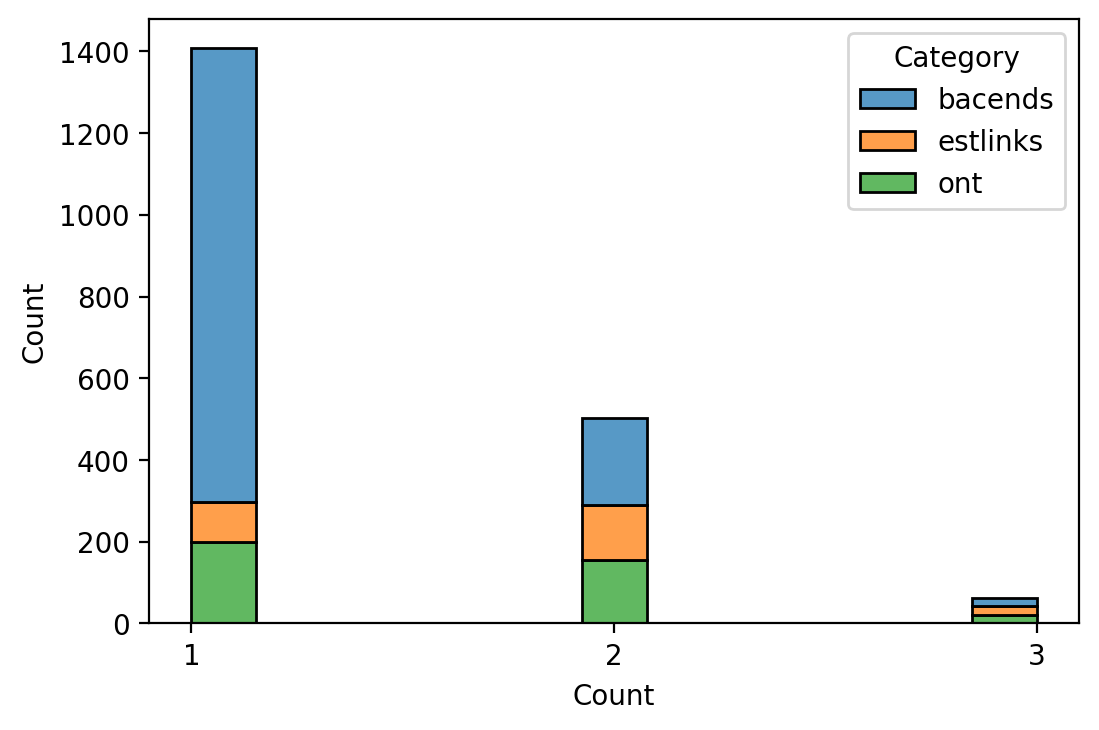

In [81]:
orgEdges = {"Category" : [], "Count" : []}

for f in ("bacends", "estlinks", "ont"):
    for index, edgeNode in enumerate(list(graphs[f].edges)):
        if edgeNode[0] in isPresent and edgeNode[1] in isPresent:
            orgEdges["Category"].append(f)
            orgEdges["Count"].append(newEdges[edgeNode])
            
g = sns.histplot(data=pd.DataFrame(orgEdges), stat="count", multiple="stack", x="Count", 
             hue="Category", element="bars", legend=True)
g.set_xticks([1,2,3])
g.set_xticklabels(["1", "2", "3"])

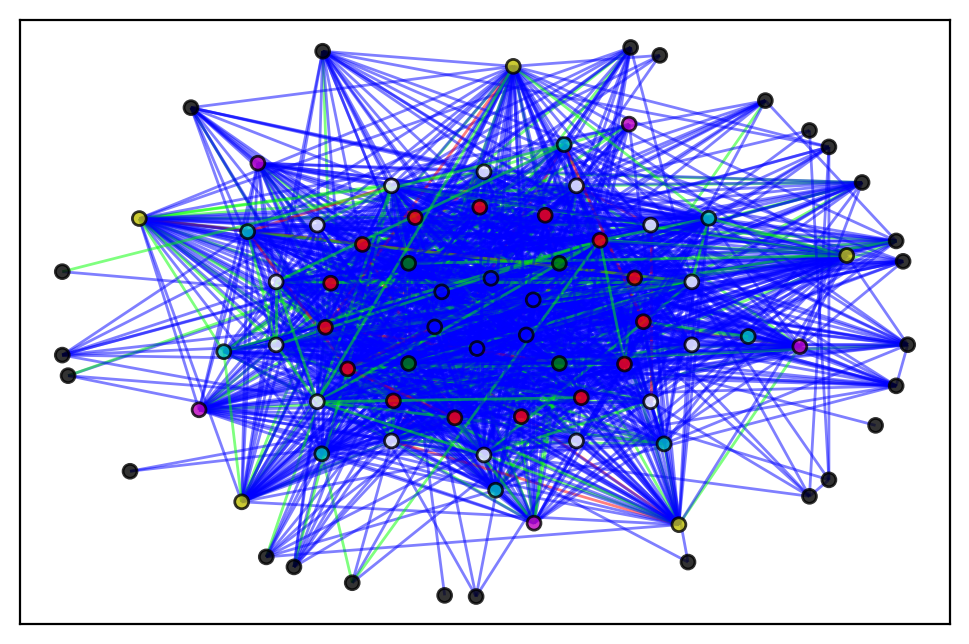

In [77]:
pos = nx.shell_layout(consolidate, nlist=nShellList)
nColors = nx.get_node_attributes(consolidate, 'color')
eColors = nx.get_edge_attributes(consolidate, 'color')
nx.draw_networkx_nodes(consolidate, pos, nodelist=[n for n in consolidate.nodes()], 
                       node_color=[nColors.get(n, 'w') for n in consolidate.nodes()], node_size=25, node_shape='o', 
                       edgecolors='k', alpha=0.8)

nx.draw_networkx_edges(consolidate, pos, edgelist=consolidate.edges(), width=1,
                       alpha = 0.5, edge_color=list(eColors.values()))

Now to create a version of the graph without the blue edges that mess things up!

A version of the graph that has only edges supported by at least two observations


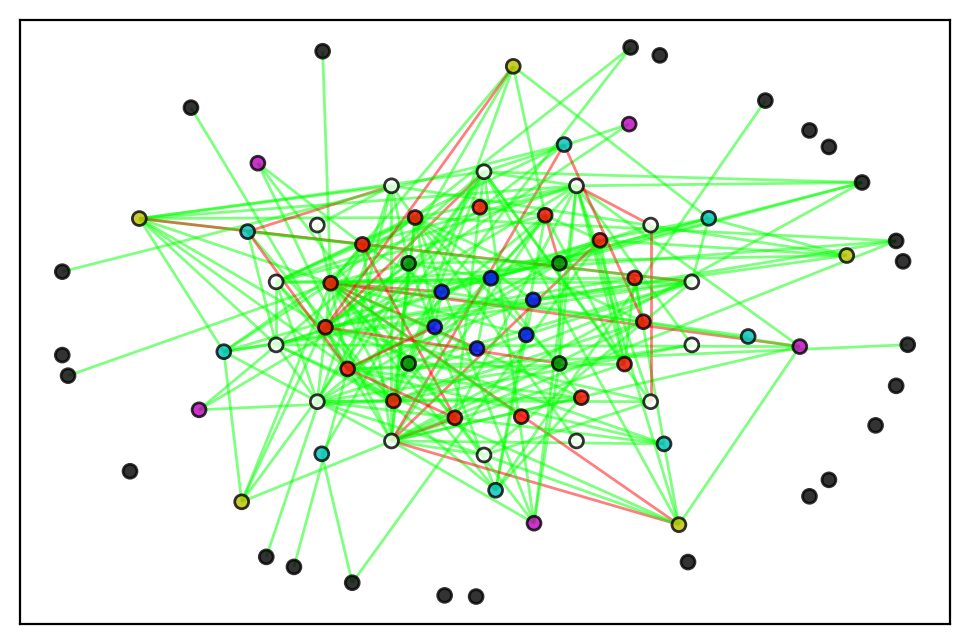

In [78]:
print("A version of the graph that has only edges supported by at least two observations")
filtered = consolidate.copy()
eWeights = nx.get_edge_attributes(filtered, 'weight')
for index, edge in enumerate(filtered.edges):
    if eWeights[edge] == 1:
        filtered.remove_edge(edge[0], edge[1])
        
eColors = nx.get_edge_attributes(filtered, 'color')
nx.draw_networkx_nodes(filtered, pos, nodelist=[n for n in filtered.nodes()], 
                       node_color=[nColors.get(n, 'w') for n in filtered.nodes()], node_size=25, node_shape='o', 
                       edgecolors='k', alpha=0.8)

nx.draw_networkx_edges(filtered, pos, edgelist=filtered.edges(), width=1,
                       alpha = 0.5, edge_color=list(eColors.values()))

---

## Wrapping things up

In light of the above information, I think that the following strategy is best -- keep all EST + ONT nodes. Assign nodes to linkage groups based on EST affiliation (using raw and ordered EST sites when possible). Then assign unassigned scaffolds to linkage groups based on 2 or more links when possible. Ambiguity in unassigned links should be ignored (ie. two or more links between different LG groups). Let's create the final graph and tables for this assignment.

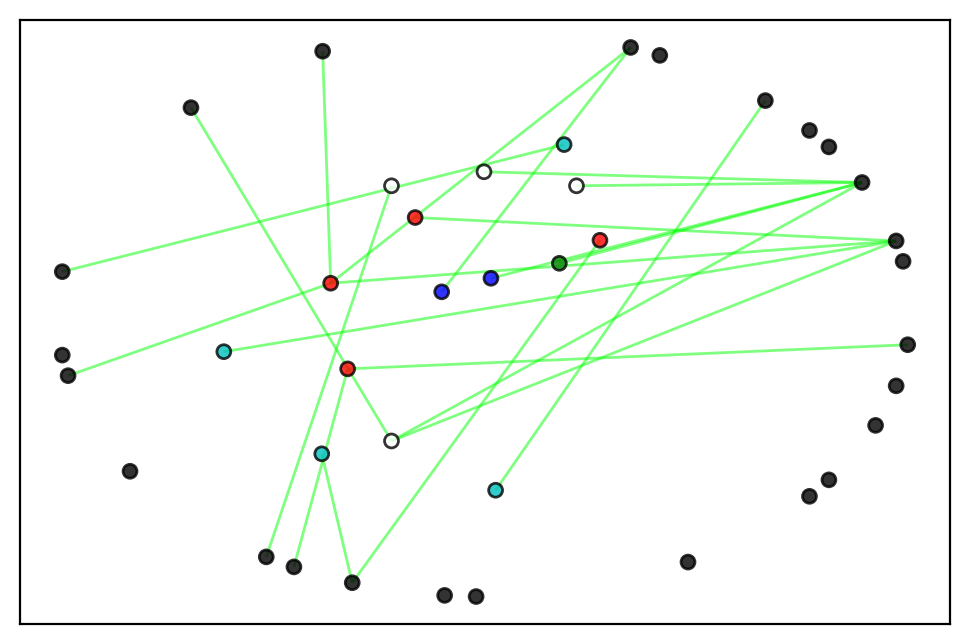

In [82]:
# Get unassigned nodes.
nColors = nx.get_node_attributes(filtered, 'color')
eWeights = nx.get_edge_attributes(filtered, 'weight')

unassigned = set()
drawNodes = set()
drawEdges = list()

for k, v in nColors.items():
    if v == 'k':
        drawNodes.add(k)
        unassigned.add(k)
        
# Loop through edges
for index, edge in enumerate(filtered.edges):
    if edge[0] in unassigned or edge[1] in unassigned:
        drawNodes.add(edge[0])
        drawNodes.add(edge[1])
        drawEdges.append(edge)
        
# Draw reduced network
eColors = nx.get_edge_attributes(filtered, 'color')
nx.draw_networkx_nodes(filtered, pos, nodelist=list(drawNodes), 
                       node_color=[nColors.get(n, 'w') for n in list(drawNodes)], node_size=25, node_shape='o', 
                       edgecolors='k', alpha=0.8)

nx.draw_networkx_edges(filtered, pos, edgelist=drawEdges, width=1,
                       alpha = 0.5, edge_color=[eColors[x] for x in drawEdges])

In [91]:
import csv
# Now to create a table to filter the final sets
fTable = {"Unassigned" : [], "LGNode" : [], "LGGroup" : []}

revLookup = {"b": "LG1", "g" : "LG2", "r" : "LG3", "w" : "LG4", "c" : "LG5", "m" : "LG6", "y" : "LG7"}

# Loop through edges
for index, edge in enumerate(filtered.edges):
    if edge[0] in unassigned or edge[1] in unassigned:
        if edge[0] in unassigned:
            fTable["Unassigned"].append(edge[0])
            fTable["LGNode"].append(edge[1])
            fTable["LGGroup"].append(revLookup[nColors[edge[1]]])
        else:
            fTable["Unassigned"].append(edge[1])
            fTable["LGNode"].append(edge[0])
            fTable["LGGroup"].append(revLookup[nColors[edge[0]]])
            
fData = pd.DataFrame(fTable)
fData = fData.sort_values(by=["Unassigned"])

fData.to_csv("C:/SharedFolders/sequencing_projects/red_clover/graph_comps/unassigned_node_scaffolds.tab", 
             sep="\t", quoting=csv.QUOTE_NONE, index=False)
print(fData)

      Unassigned       LGNode LGGroup
17  scaffold_111   scaffold_9     LG3
8   scaffold_139   scaffold_4     LG3
20  scaffold_142  scaffold_47     LG5
16   scaffold_59   scaffold_9     LG3
11   scaffold_60   scaffold_8     LG4
0    scaffold_60  scaffold_40     LG2
2    scaffold_60  scaffold_24     LG1
5    scaffold_60   scaffold_3     LG4
10   scaffold_60   scaffold_5     LG4
7    scaffold_61   scaffold_4     LG3
3    scaffold_64   scaffold_3     LG4
4    scaffold_68   scaffold_3     LG4
9    scaffold_68   scaffold_4     LG3
14   scaffold_68  scaffold_27     LG3
15   scaffold_68  scaffold_51     LG5
6    scaffold_71   scaffold_4     LG3
13   scaffold_71  scaffold_22     LG1
1    scaffold_75  scaffold_31     LG5
19   scaffold_82  scaffold_15     LG3
12   scaffold_82  scaffold_53     LG5
18   scaffold_89   scaffold_1     LG4


In [96]:
print(fData.groupby("Unassigned")['LGGroup'].nunique())

Unassigned
scaffold_111    1
scaffold_139    1
scaffold_142    1
scaffold_59     1
scaffold_60     3
scaffold_61     1
scaffold_64     1
scaffold_68     3
scaffold_71     2
scaffold_75     1
scaffold_82     2
scaffold_89     1
Name: LGGroup, dtype: int64


---

So it looks like I need to remove scaffold_60, scaffold_68, scaffold_71 and scaffold_82 from consideration due to their ambiguity. Won't be too difficult!

In [3]:
nx.__version__()

TypeError: 'str' object is not callable